# Task #5.1: find the Std Star!

What is the standard star? The (spectro)photometric standard stars are a series of reference stars whose light output have been measured very carefully.

Why do we need to observe them? We need to measure the light of at least one standard star and compare it to the well-known measurements in physical units in order to convert the flux from counts/s/Å to erg/cm²/s/Å.

How do we do this comparison? We simply extract the spectrum of the standard star, calibrate its wavelength axis and compare it with the spectrum in physical units downloaded from the internet.

In [14]:
# Importing all needed packages
# Standard packages for data visualization and modeling
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
%matplotlib notebook

# Packages for reading astronomical data stored in fits files and accessing file paths
from astropy.io import fits  # to read fits files with python
import glob  # to find pathnames

# Packages for importing ad-hoc modules 
import importlib
import sys
#importlib.reload(sys.modules['data_reduction']) # uncomment when you edit the module data_reduction.py
from data_reduction import *

# Other
import datetime
import timeit
from regions import RectanglePixelRegion
from IPython.display import IFrame   # to open and view a pdf in the notebook

First thing is to identify the frame of the observed standard star and its pathname.

In [15]:
# ALAe130155 is the frame of the standard star BD+33
path2data = '/home/masi1109/Documents/PhD/ObsII/not2mattia'
file = path2data + "/ALAe130155_b_f.fits"

# Check standard star frame and localize the source

In the cell below we access the standard star frame and check and print the following information:

-> pathname

-> standard star name

-> airmass (coefficient for atmospheric absorption)

-> history of the file: has it been bias-subtracted and flat-normalized?

We plot below a frame image and the flux profile (as a function of the spatial coordinate x)

/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130155_b_f.fits 
Standard star name: BD+33
Airmass: 1.1853044941568
HISTORY: Master Bias subtracted on 2021-02-19 17:32:48 using master bias file /ho
me/masi1109/Documents/PhD/ObsII/not2mattia/master_bias_mean.fits
Master flat divided on: 2021-02-19 17:33:45 using master flat file /home
/masi1109/Documents/PhD/ObsII/not2mattia/master_flat_mean.fits


<IPython.core.display.Javascript object>


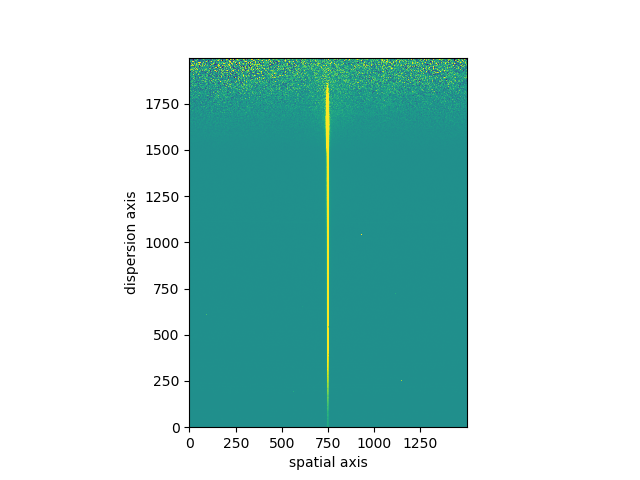

<IPython.core.display.Javascript object>


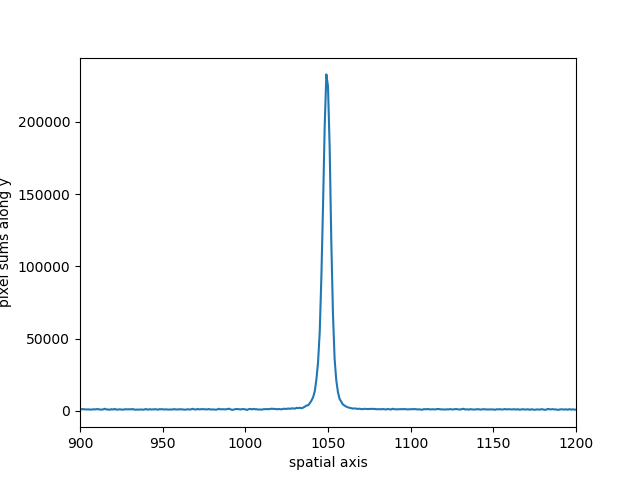

Text(0, 0.5, 'pixel sums along y')

In [16]:
# Printing basic checks

hdul = fits.open(file)  # reading the fits file (headers and pixel values)
    
# Region of interest for data calibration
xmin, xmax, ymin, ymax = 300, 1800, 0, 2000 
    
if hdul[0].header['IMAGETYP'] == 'OBJECT' and hdul[0].header['OBS_MODE'] == 'SPECTROSCOPY':
    print(file, "\nStandard star name:", hdul[0].header['OBJECT'])
    airmass_std = hdul[0].header['AIRMASS']
    print("Airmass:", airmass_std)
    
    # checking bias subtraction and flat normalization
    flat_check = hdul[0].header['HISTORY']
    print("HISTORY:", flat_check)
    
    frame = hdul[1].data
    f = frame[ymin:ymax, xmin:xmax]
    plt.figure()
    plt.imshow(f, origin='lower', vmin=np.median(f)-2*np.std(f), 
                vmax=np.median(f)+2*np.std(f))
    plt.xlabel("spatial axis")
    plt.ylabel("dispersion axis")
        
hdul.close()

# Specify the y-coordinate range (dispersion axis) of interest for computing the flux profile
yrange_min = 200
yrange_max = 220
        
# Plotting the flux profile along the spatial axis (x)
x_px = np.arange(xmin, xmax)
ysums = frame[yrange_min:yrange_max,:].sum(axis=0)
plt.figure()
plt.plot(x_px, ysums[xmin:xmax], label="flux profile")
plt.xlim(900,1200)
plt.xlabel("spatial axis")
plt.ylabel("pixel sums along y")

# Define aperture window for standard star

In order to define an aperture in this frame, we repeat the same procedure done in workbook #3 using the continuum-traing technique.

Standard Deviation of the Gaussian searched in the range:  1.2739827004320283 6.369913502160141 pix



<IPython.core.display.Javascript object>


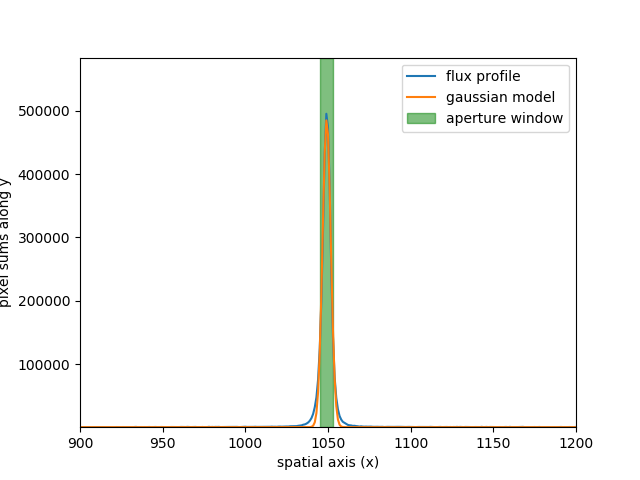

In [17]:
# What aperture parameters do you want, approximately? Please specify based on the SN flux profile above!
amp = 4.1e6  # amplitude of the peak
x_cen = 1049  # central x coordinate
sigma = 3  # standard deviation

# Please write here these other important properties of the observations (check on the logs!)
seeing = 0.6  # seeing FWHM (in arcsec) 
pix_scale = 0.2  # pixel scale (in arcsec/pc) / Matthew told me so (but check on the header...) 

min_sigma = seeing / pix_scale / (2*np.sqrt(2*np.log(2)))  # profile width can't be smaller than this
max_sigma = 5*min_sigma
print("Standard Deviation of the Gaussian searched in the range: ", min_sigma, max_sigma, "pix\n")

# In order to define the extraction aperture, we fit the flux profile with a gaussian
# that will be used to extract the spectrum as a weight when summing pixels along x axis

# Since the position (x) of the source can vary as a function of the dispersion coordinate (y)
# the fit is done for several horizontal stripes of width dy=20 pixels

dy = 10 #  stripes of 10px width
ys = []
xs_min = []
xs_max = []
amps = []
means = []
stddevs = []

for yrange_min in np.arange(200, 1200, dy): 
    
    # Flux profile - Data
    yrange_max = yrange_min + dy
    ysums = frame[yrange_min:yrange_max,:].sum(axis=0) 
    
    # Gaussian Model
    g_init = models.Gaussian1D(amplitude=amp, mean=x_cen, stddev=sigma,   
                           bounds={"mean" : [1040,1060], "stddev" : [min_sigma,max_sigma]})
    fit_g = fitting.LevMarLSQFitter()
        
    # I want to fit only the right side of the SN profile caus the left is contaminated by the galaxy
    xfit_min = int(x_cen - max_sigma)
    xfit_max = xmax
    xfit = np.arange(xfit_min, xfit_max)
    const = np.median(ysums[700:900])  # constant signal (gaussian is on top of that)
    g = fit_g(g_init, xfit, ysums[xfit_min:xfit_max]-const)
    
    # Save window properties in arrays
    ys.append((yrange_min+yrange_max)/2)
    xs_min.append(int(g.mean - 2*g.stddev))
    xs_max.append(int(g.mean + 2*g.stddev))
    amps.append(g.amplitude[0]) #  these model attributes are of the form Parameter('amplitude', value=15937)
    means.append(g.mean[0]) #  [0] gives the value only
    stddevs.append(g.stddev[0]) #  which is all we need
    
    # Reset the initial guesses as best fit values of this stripe
    amp = g.amplitude
    x_cen = g.mean
    sigma = g.stddev
    
    # Uncomment if you wan to check the best-fit gaussian parameters of each stripe
    #print (yrange_min, amps[-1], means[-1], stddevs[-1] )
    
    # Plot the fit of stripe at y of your choice
    if yrange_min == 920:
        plt.figure()
        plt.xlabel("spatial axis (x)")
        plt.ylabel("pixel sums along y")
        plt.plot(x_px, ysums[xmin:xmax], label="flux profile")
        plt.plot(x_px, g(x_px)+const, label="gaussian model")
        xrange = (x_px > xs_min[-1]) & (x_px < xs_max[-1])
        plt.fill_between(x_px, 0.9*const, 1.2*(const+g.amplitude), xrange==1, alpha=0.5, color='green', 
                     label="aperture window")
        plt.ylim(0.9*const, 1.2*(const+g.amplitude))
        plt.legend()
        plt.xlim(900, 1200)

# Save window properties and extract spectrum of standard star

We save the aperture window both in a variable and a file and use it to extract a spectrum.
We plot below the properies of the aperture window (gaussian amplitude, central coordinate and standard deviation) as a function of the dispersion coordinate.

The last plot is the extracted spectrum of the standard star.

<IPython.core.display.Javascript object>


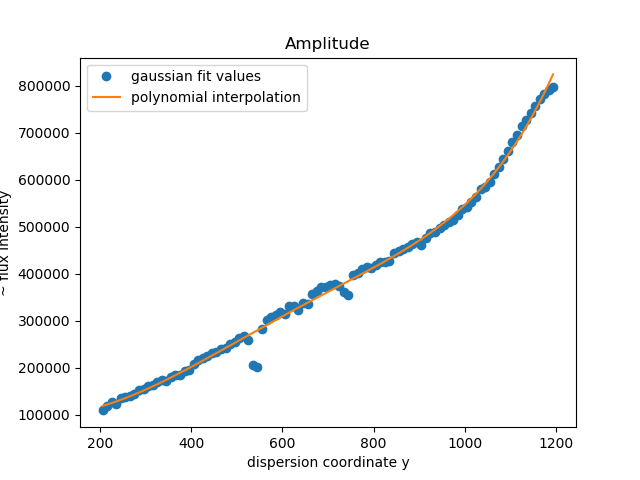

<IPython.core.display.Javascript object>


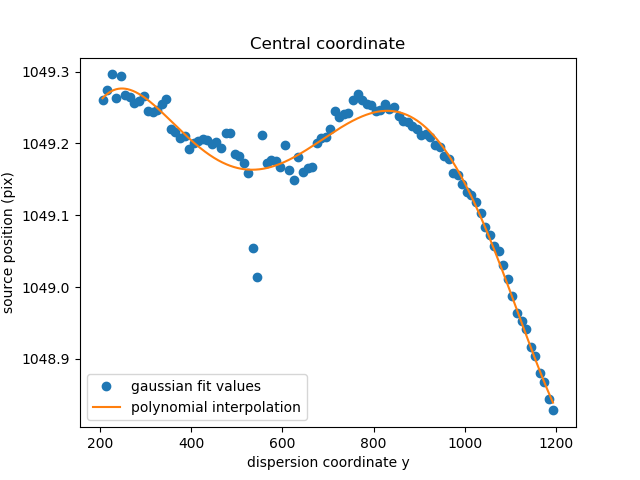

<IPython.core.display.Javascript object>


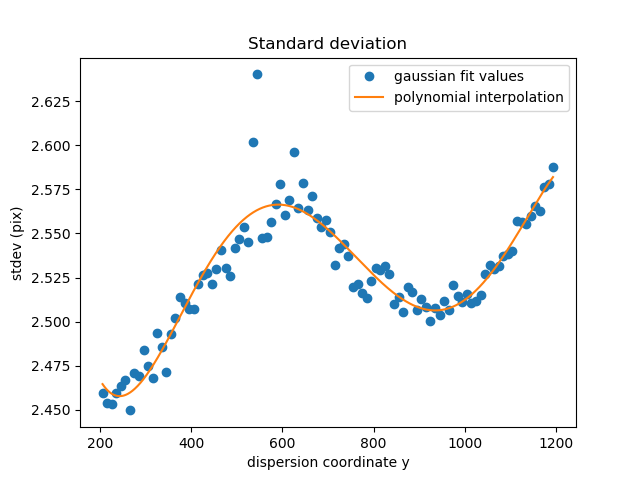

<IPython.core.display.Javascript object>


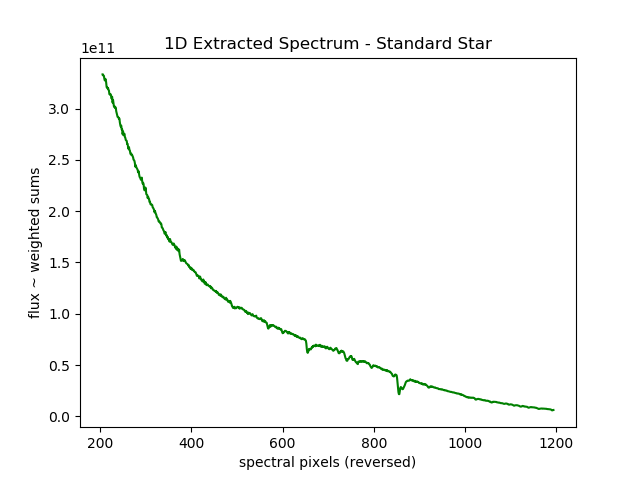

In [18]:
# Define the aperture window with the properties derived above
window_std = ExtractionWindow(xs_min, xs_max, ys, amps, means, stddevs)

# Save the window with its properties into a pickle file
import pickle
pickle.dump(window_std, open(path2data+"/ALAe130155_window.p", "wb"))

# Use the window defined above to extract the spectrum
# For each spectral pixel (y-coordinate) the flux is proportional to the sum 
# of the pixels along the spatial axis (x) weighted with the fitted gaussian

# Computing the spectrum using a function defined in data_reduction.py
# The function interpolates the gaussian parameters fitted above and plot them as a function of y
spec_px_std, flux_std = extract_spectrum(frame, window_std)
    
# Plotting the spectrum
plt.figure()
plt.title("1D Extracted Spectrum - Standard Star")
plt.plot(spec_px_std, flux_std, c='green')
plt.xlabel("spectral pixels (reversed)")
plt.ylabel("flux ~ weighted sums")
plt.savefig("figs/Std_spectrum_uncalibrated.pdf")

# Saving the spectrum in a text file
file_out = open(path2data+"/ALAe130155_1dSpectrum.txt", "w")
file_out.write("# 1d spectrum optimally extracted from frame ALAe130155_b_f.fits\n")
file_out.write("# Column 1: pixel    Column 2: flux\n")

for i in range(len(spec_px_std)):
    s = '{:d}    {:.4f}\n'.format(spec_px_std[i], flux_std[i])
    file_out.write(s)
    
file_out.close()

# Calibrating the wavelengths
# Do I need to extract the spectrum of the arc lamp using the same window used for the standard star?

# Calibrate wavelengths

We calibrate the wavelength axis of the standard star spectrum with the same method used in the previous workbook:

-> we open the lamp frame 

-> we extract the lamp spectrum using the aperture defined above for the standard star

-> we compare a few emission lines of the lamp spectrum with the line atlas

-> we find an approximate dispersion solution

/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130155_b_f.fits 
Image type: WAVE,LAMP Obs. Mode: SPECTROSCOPY
HISTORY: Master Bias subtracted on 2021-02-19 17:32:48 using master bias file /ho
me/masi1109/Documents/PhD/ObsII/not2mattia/master_bias_mean.fits
Master flat divided on: 2021-02-19 17:33:45 using master flat file /home
/masi1109/Documents/PhD/ObsII/not2mattia/master_flat_mean.fits


<IPython.core.display.Javascript object>


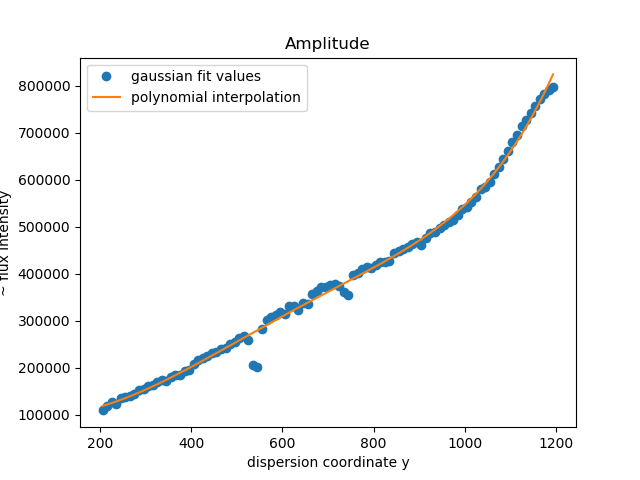

<IPython.core.display.Javascript object>


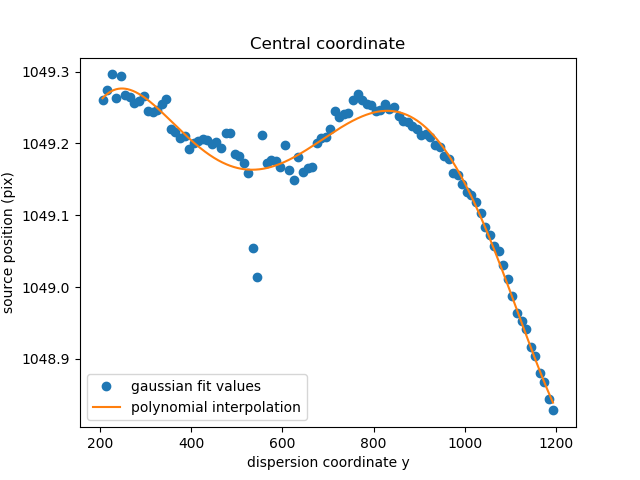

<IPython.core.display.Javascript object>


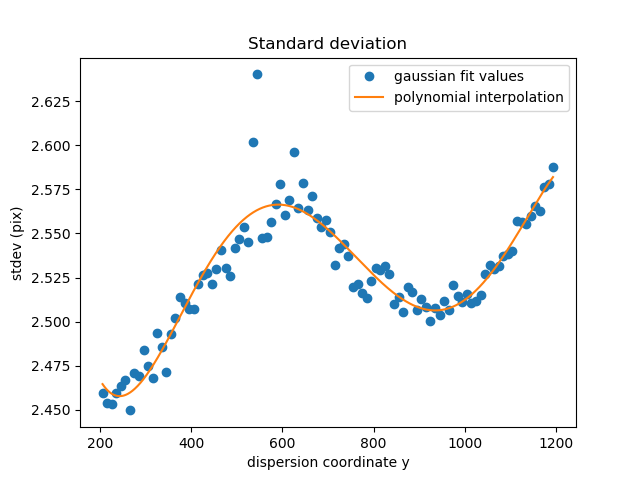

<IPython.core.display.Javascript object>


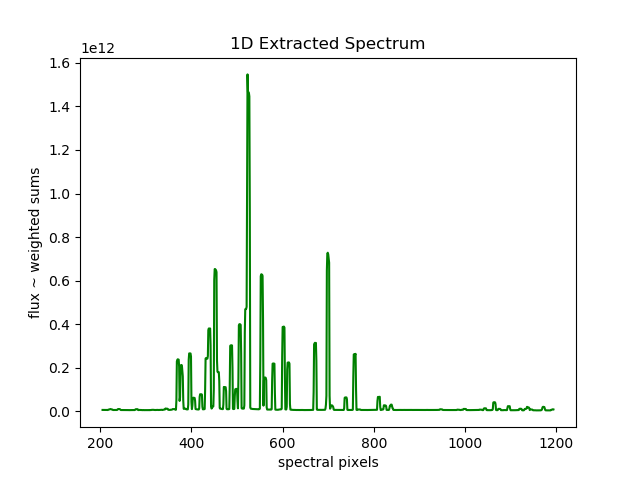

<IPython.core.display.Javascript object>


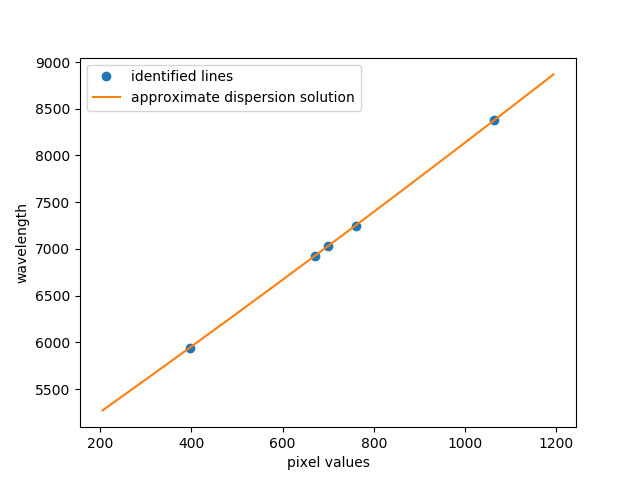

In [19]:
# Check the arc lamp frame
file_arc = path2data + "/ALAe130146_b_f.fits"
hdul = fits.open(file_arc)  # reading the fits file (headers and pixel values)

# Region of interest for data calibration
xmin, xmax, ymin, ymax = 300, 1800, 200, 1500 
    
if hdul[0].header['IMAGETYP'] == 'WAVE,LAMP' and hdul[0].header['OBS_MODE'] == 'SPECTROSCOPY':
    print(file, "\nImage type: WAVE,LAMP", "Obs. Mode: SPECTROSCOPY")
        
    # checking bias subtraction and flat normalization
    flat_check = hdul[0].header['HISTORY']
    print("HISTORY:", flat_check)
    
    frame_arc = hdul[1].data

# We want to use the same aperture window defined above for the std star 
# to extract the spectru from the arc lamp frame

spec_px_arc, flux_arc = extract_spectrum(frame_arc, window_std)

# Plotting the spectrum
plt.figure()
plt.title("1D Extracted Spectrum")
plt.plot(spec_px_arc, flux_arc, c='green')
plt.xlabel("spectral pixels")
plt.ylabel("flux ~ weighted sums")

# For start, identify a few lines referring to the NOT line atlas of the correct grism and lamp
# please find this at http://www.not.iac.es/instruments/alfosc/lamps/
atlas_name = '/home/masi1109/Documents/PhD/ObsII/map-g04-ne-1.pdf'
IFrame(atlas_name, width=512, height=512) 

# Write down the pixel values of the lines in the extracted spectrumm 
# and the corresponding wavelength in the atlas

# old
p0, p1, p2, p3, p4 = 397, 670, 700, 760, 1064
w0, w1, w2, w3, w4 = 5944.8342, 6929.468, 7032.4127, 7245.1670, 8377.6070

# Fit a low-order polynomial to get an approximate dispersion relation
# that can be used to ocnvert wavelengths in Å to pixel values
xs = [p0, p1, p2, p3, p4]
ys = [w0, w1, w2, w3, w4]
quadratic_fit = np.polyfit(xs, ys, 2)
disp_sol = np.polyval(quadratic_fit, spec_px_arc)
from_lam_to_pix = sp.interpolate.interp1d(disp_sol, spec_px_arc, fill_value='extrapolate')

plt.figure()  # plotting an approximate dispersion relation
plt.plot(xs, ys, 'o', label='identified lines')
plt.plot(spec_px_arc, disp_sol, label='approximate dispersion solution')
plt.xlabel("pixel values")
plt.ylabel("wavelength")
plt.legend()

# Get access to the IRAF list (fits file of the lamp frame says He and Ne lamps are on)
list_file = "line_atlas/IRAF_arclamp_linelist_Ne.txt"
lam = np.loadtxt(list_file, usecols=[0])
pix = from_lam_to_pix(lam)

We can now use the same lines and procedure that we used in the previous workbook to derive the true dispersion relation.
Below we plot the gaussian fits for the emission lines, the true dispersion relation, the residuals and the wavelength-calibrated spectrum of the standard star. We save this as a text file in the data directory.

<IPython.core.display.Javascript object>


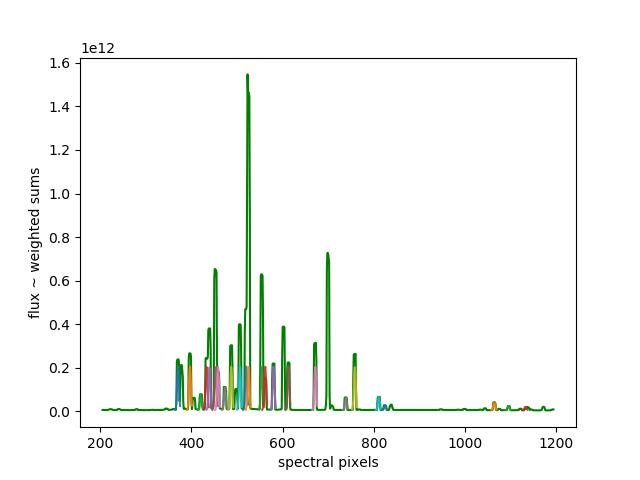

<IPython.core.display.Javascript object>


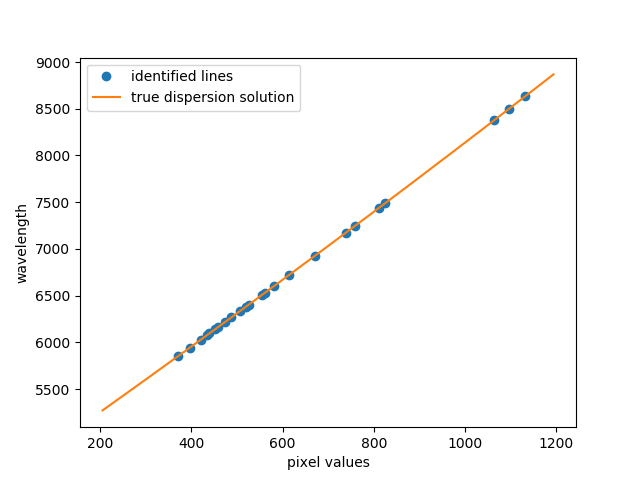

<IPython.core.display.Javascript object>


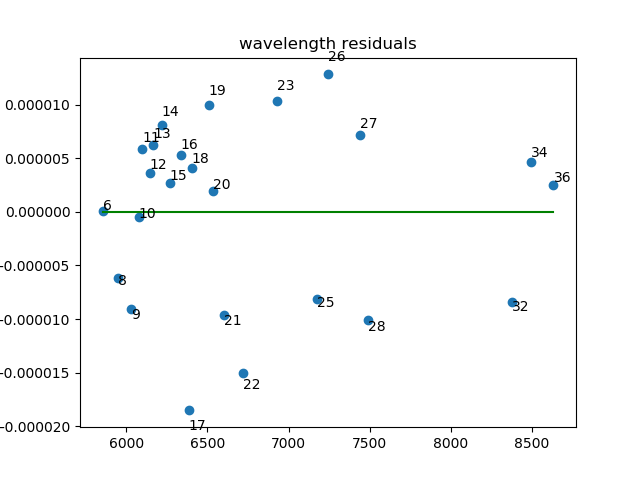

wavelength rms = 8.360328953317288e-06


<IPython.core.display.Javascript object>


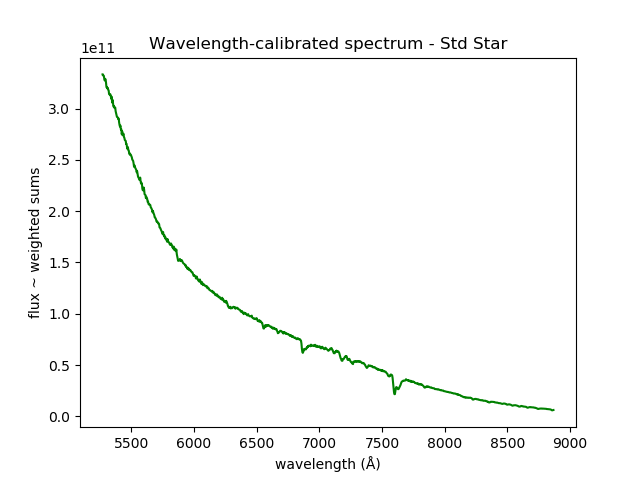


NB When you run twice the cell above, you will get a funky output.Run all cells of the workbook at once to be on the safe side


In [20]:
# Write the lines number of the chosen line to find the true dispersion solution (~20) 
# elongate the plot below vertically to display fully the legend and zoom into the line

chosen_lines = [6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,32,34,36]

# Find exact centroids of the chosen lines
# by fitting the emission lines one by one taking as initial guesses the values in the lam array
cen_pix = []
cen_lam = []
plt.figure()    
plt.plot(spec_px_arc, flux_arc, c="green")
plt.xlabel("spectral pixels")
plt.ylabel("flux ~ weighted sums")

for j in chosen_lines:
    sigma = 2
    # Interval where to fit the emission line:
    xfit_min = int(pix[j]-3*sigma) - spec_px_arc.min()
    xfit_max = int(pix[j]+3*sigma) - spec_px_arc.min()
    xfit = np.arange(xfit_min, xfit_max)
    const = 5.5e9  # continuum level of the arc lamp (check above!)
    amp = flux_arc[xfit].max() - const
    
    g_init = models.Gaussian1D(amplitude=amp, mean=pix[j], stddev=sigma,   
                           bounds={"stddev" : [1, 5], "amplitude" : [1e9, 2e11]})
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, xfit, flux_arc[xfit_min:xfit_max] - const)
    plt.plot(spec_px_arc[xfit], g(spec_px_arc[xfit])+const, alpha=0.9)  # plotting the guassian models
    
    cen_pix.append(g.mean[0])
    cen_lam.append(lam[j])

# Linear Regression centroids (pixels) vs central wavelenghts
real_fit = np.polyfit(cen_pix, cen_lam, 2)
real_sol = np.polyval(real_fit, spec_px_arc)
from_pix_to_lam = sp.interpolate.interp1d(spec_px_arc, real_sol, fill_value='extrapolate')

plt.figure()  # plotting the true dispersion relation
plt.plot(cen_pix, cen_lam, 'o', label='identified lines')
plt.plot(spec_px_arc, real_sol, label='true dispersion solution')
plt.xlabel("pixel values")
plt.ylabel("wavelength")
plt.legend()


# Goodness of fit
fit_lam = np.polyval(real_fit, cen_pix)
N = len(cen_pix)
lam_rms = np.sqrt ( sum ( (fit_lam - cen_lam)**2 ) / N)

plt.figure()  # plotting the residuals of the linear regression
plt.title('wavelength residuals')
plt.plot(cen_lam, (cen_lam - fit_lam), 'o')
plt.plot(cen_lam, np.zeros(len(cen_lam)), c='green')
for i,j in zip(chosen_lines, range(len(cen_lam))):
    plt.text(cen_lam[j], 1.1*(cen_lam[j] - fit_lam[j]), str(i))
    
print("wavelength rms = " + str(lam_rms))

# Import the uncalibrated spectrum of the std star
pix, fpix = np.loadtxt(path2data+"/ALAe130155_1dSpectrum.txt", unpack=True)
lam_std = from_pix_to_lam(pix)  # array of wavelengths
plt.figure()
plt.plot(lam_std, fpix, c="green")
plt.title("Wavelength-calibrated spectrum - Std Star")
plt.xlabel("wavelength (Å)")
plt.ylabel("flux ~ weighted sums")
plt.savefig("figs/Std_spectrum_wav-cal.pdf")

# Saving the calibrated spectrum in a text file
file_out = open(path2data+"/ALAe130155_1dSpectrum_wav-cal.txt", "w")
file_out.write("# 1d spectrum optimally extracted from frame ALAe130155_b_f.fits\n")
file_out.write('# Wavelength calibrated')
file_out.write("# Column 1: wavelength (Å)    Column 2: flux (uncalibrated)\n")

for i in range(len(pix)):
    s = '{:.4f}    {:.4f}\n'.format(lam_std[i], fpix[i])
    file_out.write(s)
    
file_out.close()

print("\nNB When you run twice the cell above, you will get a funky output.\
Run all cells of the workbook at once to be on the safe side")